# Homework 4
### Problem 4.1

In [246]:
origdata <- read.csv("monthlyRets-clean.csv", header = TRUE)

In [247]:
cols <-colnames(origdata)
date <- origdata['DATE']

n <- (length(cols)-1)/2
ret_cumsum <-data.frame(Date = date)

for(i in 1:n){
    j <- 2*i + 1
    cumsum_temp <- cumsum(origdata[,j])
    ret_cumsum[cols[j]]<-cumsum(origdata[j])
}

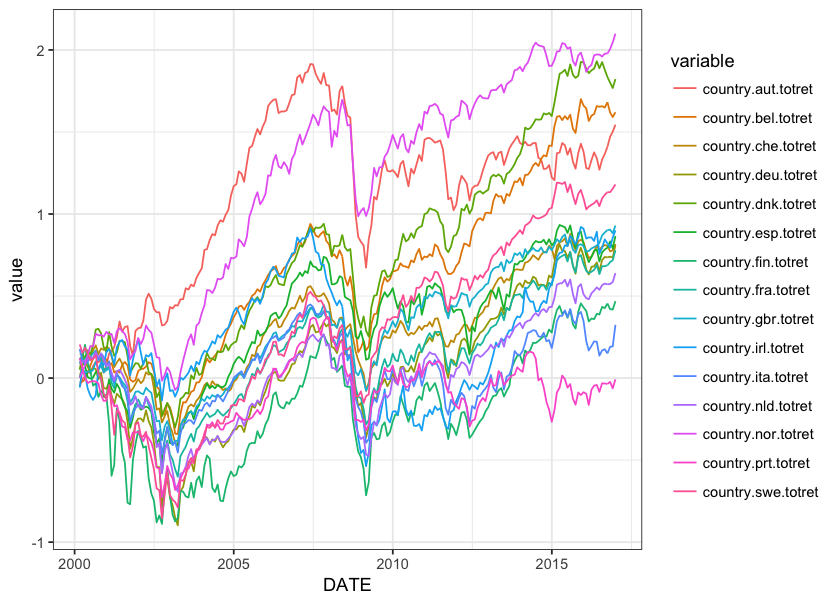

In [248]:
library(ggplot2)
library(reshape2)
library(repr)
options(repr.plot.height=5)

ret_melt <- melt(ret_cumsum, id.vars = "DATE")
ret_melt$DATE <-as.Date(ret_melt$DATE)

ggplot(ret_melt, aes(x = DATE, y = value, color = variable)) +
  theme_bw() +
  geom_line()

### Problem 4.2

In [249]:
origdata["DATE"] <- as.Date(origdata[["DATE"]])

In [250]:
cols <-colnames(origdata)
date <- origdata['DATE']

n <- (length(cols)-1)/2
capdata <- data.frame(Date = date)
retdata <- data.frame(Date = date)

for(i in 1:n){
    k <- 2*i
    j <- 2*i + 1
    retdata[cols[j]]<-origdata[j]
    capdata[cols[k]]<- origdata[k]
}

In [331]:
Sigma_connum <- function(shrinkage, retdata, t ="2016-12-31"){
    data <- retdata[retdata[["DATE"]]<=t, ]
    vols <- c()
    
    for(i in 2:16){vols <- c(vols, sd(data[[i]]))}

    S <- diag(vols)
    R <- cor(subset(data, select = -c(DATE)))

    size <- dim(R)[1]
    iDent <- diag(size)
    Conv <- S %*% (shrinkage*R + (1-shrinkage)*iDent) %*% S
    return(list(kappa = kappa(Conv,exact = TRUE), Conv = Conv))
}

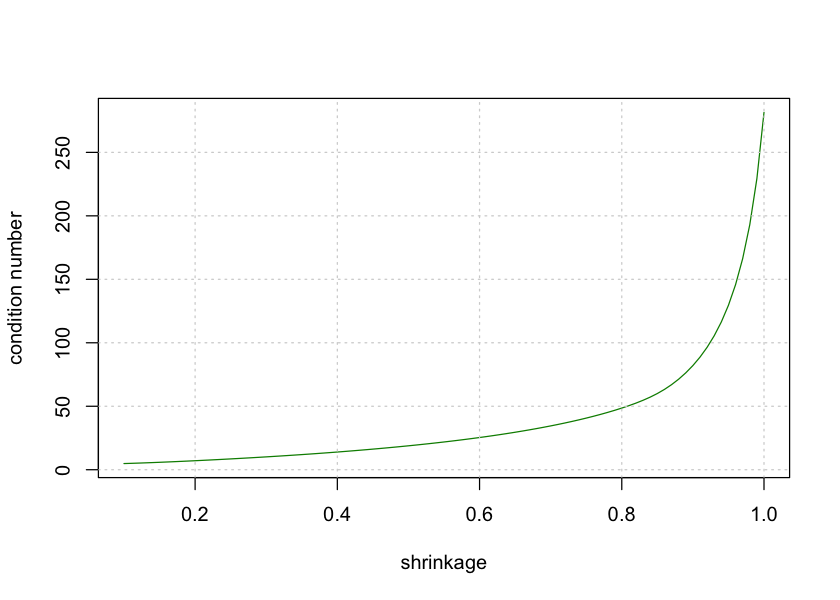

In [332]:
shrkg <- seq(0.1, 1, 0.01)
condition_num <- sapply(shrkg, Sigma_connum, retdata = retdata)["kappa",]
plot(shrkg, condition_num, xlab = "shrinkage", ylab = "condition number", type='l', col='green4')
grid()

Comment:

### Problem 4.3

In [235]:
Scandcap <- c('country.nor.previous.usdcap','country.swe.previous.usdcap', 'country.dnk.previous.usdcap', 'country.fin.previous.usdcap')
Scandret <- c('country.nor.totret','country.swe.totret', 'country.dnk.totret', 'country.fin.totret')

In [685]:
Get_weights <- function(capdata, t){
    capcols <- colnames(capdata)
    n <- length(capcols)
    nonScandcapdata <- capdata[,-which(names(capdata) %in% Scandcap)]
    sum <- sum(nonScandcapdata[nonScandcapdata[["DATE"]]==t,][-1])
    weights <- list()
    for(i in 2:n){
        if(any(capcols[i] %in% Scandcap)){
            weights[capcols[i]] <- 0.25
        }
        else{
            weights[capcols[i]] <- -(capdata[capdata[["DATE"]]==t,i]/sum)
        }
    }
    return(weights)
}

#Get_weights(capdata, "2000-02-29")

In [686]:
Get_Omega <- function(omega){
    return(diag(omega))
}

Get_q <- function(q){
    return(as.vector(q))
}

### Problem 4.4

In [687]:
BL_portfolio <- function(capdata, retdata, t, omega=0.015, q=0.01){
    date <- capdata[["DATE"]]
    index <- which(date==t)
    tprev <- date[index-1]
    #print(date)
    
    Sigma <- Sigma_connum(0.5, retdata, tprev)$Conv
    
    capdata_t <- capdata[capdata[["DATE"]]==tprev,]
    sum <- sum(capdata_t[-1])
    h_eq <- c()
    for(i in 2:16){
        temp <- capdata_t[i]/sum
        h_eq <- c(h_eq, temp)
    }
    h_eq <- as.vector(unlist(h_eq))
    
    riskaver <- 1
    tau <- 0.01
    #q <- Get_q(q)
    #Omega <- Get_Omega(omega)
    
    Pi <- riskaver *(1+tau)*(Sigma %*% h_eq)
    P <- as.matrix(unlist(Get_weights(capdata, t)))
    C <- tau * Sigma
    
    
    H_inv <- solve(P%*%t(P)/omega + solve(C))
    h_star <- solve(H_inv + Sigma) %*% H_inv %*%(P*q/omega + solve(C)%*%Pi)/riskaver
    
    #print(h_star)
    return(list(h_star=unlist(h_star), h_eq=h_eq))
    
    
}

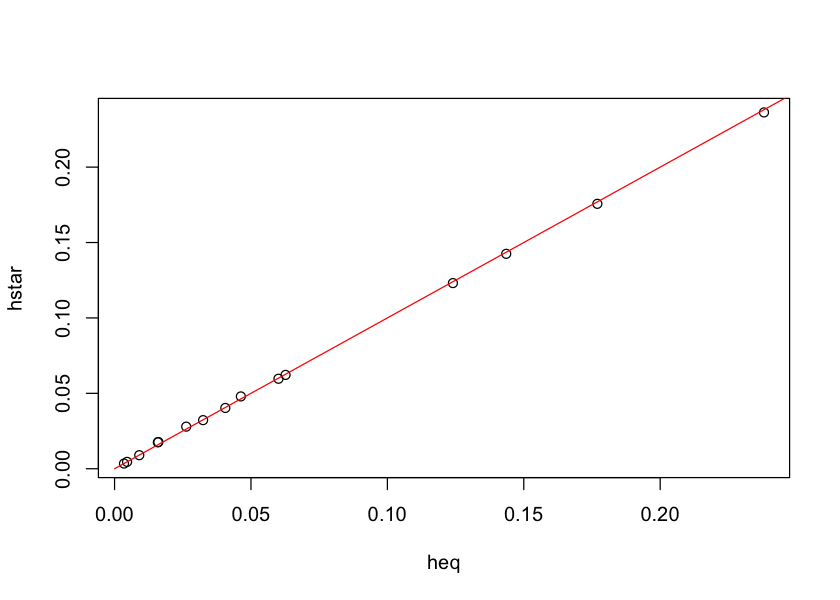

In [688]:
res <- BL_portfolio(capdata,retdata,"2016-12-31")
hstar <- res$h_star
heq <- res$h_eq
plot(x = heq, y = hstar)
curve(x*1, from=0, to =0.25,add=TRUE,col="red")

### Problem 4.5

In [696]:
time <- retdata[['DATE']]
star <- c()
eq <- c()

for(i in 51:202){
    t <- as.Date(unlist(time[i]))
    res <- BL_portfolio(capdata, retdata, t)
    hstar <- res$h_star
    heq <- res$h_eq
    r_t <- as.vector(unlist(retdata[retdata[["DATE"]]==time[i+1],][-1]))
    
    star_ret <- t(hstar)%*%r_t
    eq_ret <- t(heq)%*%r_t
    
    star<-c(star, star_ret)
    eq<- c(eq, eq_ret)
}

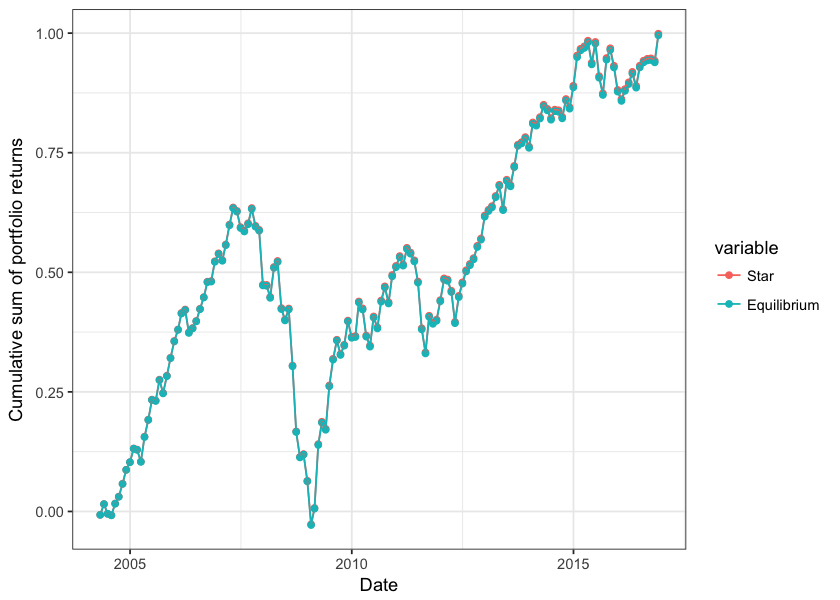

In [724]:
result <- data.frame(DATE = time[51:202], Star = cumsum(star), Equilibrium = cumsum(eq) )
result_melt <- melt(result, id.vars = "DATE")
ggplot(result_melt, aes(x = DATE, y = value, color = variable) )+
  theme_bw() +
  geom_point()+
  labs(x="Date", y = "Cumulative sum of portfolio returns")+
  geom_line()

Comment: The results are almost identical.